# K-Means Clustering using Bluetooth

<p>Jupyter Notebook which aims to explore the ML algorithm K-Means as a Clustering algorithm using the BLE technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
import sklearn
from sklearn import metrics
import scipy
from time import time

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
import seaborn as sns
#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('../radiomapBluetoothWiFiclassifier.csv')
beacon_index = find_beacon_index()
train_data = dataset.iloc[:,beacon_index:]
labels = dataset.drop(columns=['coordinate_X','coordinate_Y']).iloc[:,1:2]
reference_points = dataset.groupby(['zone'])
dict_zones = {}
counter = 0
for rp, rp_data in reference_points:
    dict_zones[rp] = counter
    counter = counter + 1
display(dict_zones)
labels['label'] = labels['zone'].map(lambda p: dict_zones[p])
display(labels)
display(train_data)

{'Bathroom': 0, 'Bedroom': 1, 'Kitchen': 2, 'Living Room': 3}

,zone,label
0,Kitchen,2
1,Kitchen,2
2,Kitchen,2
3,Kitchen,2
4,Kitchen,2
...,...,...
115,Bathroom,0
116,Bathroom,0
117,Bathroom,0
118,Bathroom,0


,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3
0,-81,-78
1,-83,-78
2,-84,-78
3,-83,-77
4,-81,-78
...,...,...
115,-78,-76
116,0,-70
117,-82,-76
118,-76,-71


## Beacons Graphical Display
Graphical display with the average strength signal transmitted by each beacon

<BarContainer object of 2 artists>

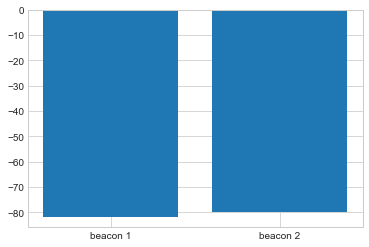

In [5]:
count_beacons = {}
counter = 1
for beacon in train_data:
    mean_value = dataset[beacon].mean()
    count_beacons['beacon ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_beacons)),list(count_beacons.values()),align='center',tick_label=list(count_beacons.keys()))

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

### Bluetooth Signal Strength

Text(0, 0.5, 'Probability')

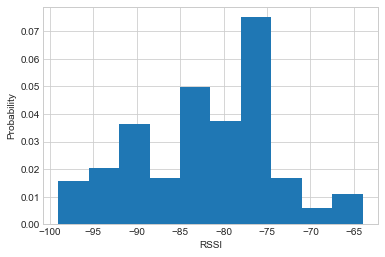

In [6]:
flatten_results = train_data.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize K-Means Parameters arrays
Initialization of the arrays with the different possible values for the parameters of K-Means function

In [5]:
init_parameter = ["k-means++", "random"]
algorithms = ["auto","full","elkan"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
precompute_distances = ["auto",True,False]
nan_filler = train_data.min().min()*1.010
train_data = train_data.fillna(nan_filler)

## Statistics Output Format
Structure of the statistical output of each call to the K-Means clustering algorithm

In [6]:
def structure_data(time_start,inertia,data,labels,estimator_labels):
    time_end = time() - time_start
    inertia = inertia
    homonegeity_score = metrics.homogeneity_score(labels,estimator_labels)
    completeness_score = metrics.completeness_score(labels,estimator_labels)
    v_measure = metrics.v_measure_score(labels,estimator_labels)
    rand_score = metrics.adjusted_rand_score(labels,estimator_labels)
    mis = metrics.mutual_info_score(labels,estimator_labels)
    statistical_results = [time_end,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis]
    return statistical_results

## Configurable KNN Classifier Function 
Configurable function to aplpy the KNN-Classifier clustering algorithm

In [7]:
def structure_data_classifier(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

In [8]:
def compute_KNN_with_Classifier(flag = 1,trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=4,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data.values.ravel())
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        display(testX_data)
        default_data_scenario = testY_data.copy()
        default_data_scenario_groups = default_data_scenario["zone"].map(str)
        predict_test = cross_val_predict(main_estimator,testX_data.values,testY_data.values.ravel(),cv = cross_validation,groups=default_data_scenario_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    # Structure data to statistics
    statistics = pd.DataFrame(report).transpose()
    statistical_array = list()
    coord_cols = ['zone']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame(np.where(predictions[coord_cols] != result[coord_cols],1,0), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    if flag == 0:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(result)
    return structure_data_classifier(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

## Configurable K-Means Function 
Configurable function to aplpy the K-Means clustering algorithm

In [9]:
statistical_cols_knn = ['mae','mse','rmse','precision','accuracy','f1-score']
def compute_KMeans(flag= 0,trainX_data = train_data,labels=labels['label'].values,n_clusters=4,init_parameter='k-means++',n_init=10,algorithms='auto',scaler = None,precompute_distances='auto',n_jobs=-1):
    # Init the KNN Regressor Estimator
    time_start = time()
    k_means_estimator = KMeans(n_clusters,init=init_parameter,n_init=n_init,random_state=5,precompute_distances=precompute_distances,n_jobs=n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,k_means_estimator)
    else:
        main_estimator = k_means_estimator
    predicted = main_estimator.fit_predict(trainX_data)
    frame = trainX_data.copy()
    frame['cluster'] = predicted
    if flag == 1:
        display(frame)
        display(frame['cluster'].value_counts())
        display(confusion_matrix(frame['cluster'],labels))
        report = classification_report(frame['cluster'],labels,output_dict = True)
        statistics = pd.DataFrame(report).transpose()
        display(statistics)
        reduced_data = PCA(n_components=2).fit_transform(trainX_data)
        results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
        sns.scatterplot(x="pca1", y="pca2", hue=frame['cluster'], data=results)
        plt.title('K-means Clustering with 2 dimensions')
        plt.show()
    elif flag == 2:
        display(frame)
        display(frame['cluster'].value_counts())
        display(confusion_matrix(frame['cluster'],labels))
        report = classification_report(frame['cluster'],labels,output_dict = True)
        statistics = pd.DataFrame(report).transpose()
        display(statistics)
        reduced_data = PCA(n_components=2).fit_transform(trainX_data)
        results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
        sns.scatterplot(x="pca1", y="pca2", hue=frame['cluster'], data=results)
        plt.title('K-means Clustering with 2 dimensions')
        Y_train = dataset.iloc[:,3:4]
        result = compute_KNN_with_Classifier(flag=0,testX_data=frame,testY_data=Y_train,scaler=MaxAbsScaler(),cross_validation = 10,
                            metric = 'canberra',weights='distance',algorithm='brute')
        statistical_results = [result]
        display(statistical_cols_knn)
        display(result)
        statistics = pd.DataFrame(columns=statistical_cols_knn,data=statistical_results)
        display(statistics)
        statistical_cols_csv = ['mae','mse','rmse']
        statistical_cols_csv.append('Experimentation')
        result_csv = result[0:3]
        result_csv.append('K-Means + KNN Classifier Bluetooth')
        results_csv = [result_csv]
        results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
        results_df.to_csv('../tests_results.csv',mode='a',index=False,header=False)
    return structure_data(time_start,k_means_estimator.inertia_,trainX_data,labels,k_means_estimator.labels_)

## Experiments

### 1st Experiment - Running KMeans function with default parameters and testing data equal to training data

,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,cluster
0,-81,-78,0
1,-83,-78,0
2,-84,-78,0
3,-83,-77,0
4,-81,-78,0
...,...,...,...
115,-78,-76,0
116,0,-70,1
117,-82,-76,0
118,-76,-71,0


0    96
3    21
1     2
2     1
Name: cluster, dtype: int64

array([[27, 29, 10, 30],
       [ 2,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 0,  1, 20,  0]], dtype=int64)

,precision,recall,f1-score,support
0,0.900,0.281250,0.428571,96.000
1,0.000,0.000000,0.000000,2.000
2,0.000,0.000000,0.000000,1.000
3,0.000,0.000000,0.000000,21.000
accuracy,0.225,0.225000,0.225000,0.225
macro avg,0.225,0.070312,0.107143,120.000
weighted avg,0.720,0.225000,0.342857,120.000


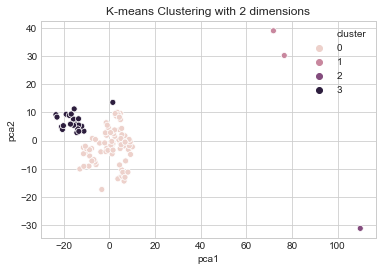

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis
0,2.225759,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821


In [12]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis']
result = compute_KMeans(flag=1,scaler=StandardScaler())
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))

### 2nd Experiment - Finding the best k parameter with Elbow Method

In [13]:
def elbow_search():
    innertia_values = {}
    distortions = []
    for i in range(1, 11):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=300, random_state=0
        )
        km.fit(train_data)
        distortions.append(km.inertia_)
        innertia_values[i] = km.inertia_
    # plot
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    display(innertia_values)

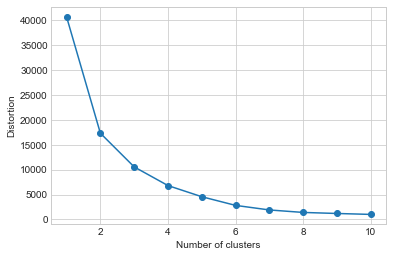

{1: 40658.91666666667,
 2: 17301.81196581196,
 3: 10542.078947368422,
 4: 6792.078947368422,
 5: 4557.164069264069,
 6: 2816.9141025641024,
 7: 1902.1299961861175,
 8: 1405.6392551892552,
 9: 1195.9399749373433,
 10: 1009.2927887901573}

In [14]:
best_k = elbow_search()

### 3rd Experiment - Running the K-Means function with the different init_parameters

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,init_parameter
1,0.023984,63.979796,0.335760,0.432821,0.378162,0.229918,0.465462,random
0,1.945880,47.909045,0.215554,0.505047,0.302150,0.126776,0.298821,k-means++


Selected Init Parameter:  random


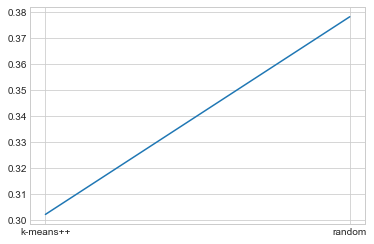

In [10]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','init_parameter']
results = list()
for param in init_parameter:
    result = compute_KMeans(scaler=StandardScaler(),init_parameter=param)
    result.append(param)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))
plt.plot(statistics['init_parameter'],statistics['v_measure'])
selected_init_param = statistics.sort_values(by=['v_measure'],ascending=False)['init_parameter'].head(1).values[0]
print("Selected Init Parameter: ",selected_init_param)

### 4th Experiment - Running the K-Means function with the different preprocessing

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,preprocessing,preprocessingFunc
0,0.033982,47.909045,0.215554,0.505047,0.302150,0.126776,0.298821,StandardScaler,"StandardScaler(copy=True, with_mean=True, with..."
1,0.021983,0.696130,0.186470,0.338204,0.240396,0.146551,0.258502,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))"
2,0.023986,0.696130,0.186470,0.338204,0.240396,0.146551,0.258502,MaxAbsScaler,MaxAbsScaler(copy=True)
3,0.025985,6792.078947,0.186470,0.338204,0.240396,0.146551,0.258502,None,None


Selected Preprocessing:  StandardScaler


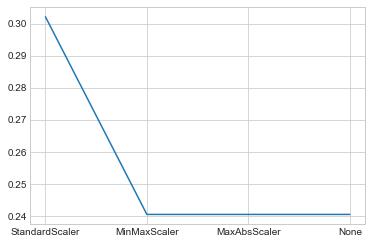

In [11]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler:
    result = compute_KMeans(scaler = preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))
plt.plot(statistics['preprocessing'],statistics['v_measure'])
selected_preprocessing = statistics.sort_values(by=['v_measure'],ascending=False)['preprocessing'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 5th Experiment - Running the KMeans function with the different algorithms

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,algorithm
0,0.024984,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,auto
1,0.028984,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,full
2,0.031982,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,elkan


Selected Algorithm:  auto


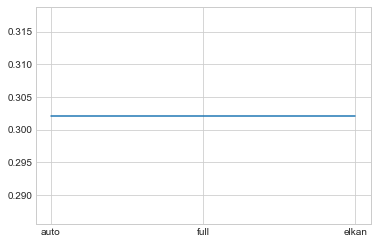

In [12]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','algorithm']
results = list()
for algorithm in algorithms:
    result = compute_KMeans(scaler = StandardScaler(),algorithms=algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))
plt.plot(statistics['algorithm'],statistics['v_measure'])
selected_algorithm = statistics.sort_values(by=['v_measure'],ascending=False)['algorithm'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 6th Experiment - Running the KMeans function with the different preprocessing distance values

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,distance,distanceStr
0,0.022988,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,auto,auto
1,0.029984,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,True,True
2,0.028984,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,False,False


Selected Distance:  auto


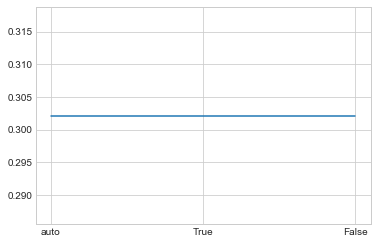

In [13]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','distance','distanceStr']
results = list()
for distance in precompute_distances:
    result = compute_KMeans(scaler = StandardScaler(),precompute_distances=distance)
    result.append(distance)
    result.append(str(distance))
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))
plt.plot(statistics['distanceStr'],statistics['v_measure'])
selected_distance = statistics.sort_values(by=['v_measure'],ascending=False)['distanceStr'].head(1).values[0]
print("Selected Distance: ",selected_distance)

### 7th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [14]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','init_parameter','preprocessing','algorithm','distance']
results = list()
k_range = range(1, 31)
for param in init_parameter:
    for preprocessing in scaler:
        for algorithm in algorithms:
            for distance in precompute_distances:
                result = compute_KMeans(scaler=preprocessing,init_parameter=param,algorithms=algorithm,precompute_distances=distance)
                if(preprocess is None):
                    regex = 'None'
                else:
                    regex = re.search('(\w+)\(',str(preprocess)).group(1)
                result.append(param)
                result.append(regex)
                result.append(algorithm)
                result.append(distance)
                results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,init_parameter,preprocessing,algorithm,distance
36,0.031981,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462,random,None,auto,auto
44,0.025985,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462,random,None,elkan,False
43,0.026984,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462,random,None,elkan,True
42,0.026984,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462,random,None,elkan,auto
41,0.023988,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462,random,None,full,False
...,...,...,...,...,...,...,...,...,...,...,...
33,0.029982,6792.078947,0.18647,0.338204,0.240396,0.146551,0.258502,k-means++,None,elkan,auto
34,0.025984,6792.078947,0.18647,0.338204,0.240396,0.146551,0.258502,k-means++,None,elkan,True
35,0.027986,6792.078947,0.18647,0.338204,0.240396,0.146551,0.258502,k-means++,None,elkan,False
10,0.052970,0.696130,0.18647,0.338204,0.240396,0.146551,0.258502,k-means++,None,auto,True


### 14th Experiment: Running the K-Means function with data filtered 

In [15]:
def apply_filter():
    statistical_cols =  ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_KMeans(scaler=StandardScaler())
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['v_measure'],ascending=False))
    plt.plot(statistics['filter'],statistics['v_measure'])
    selected_filter = statistics.sort_values(by=['v_measure'],ascending=False)['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter

def get_median_filter():
    medians = list()
    aps = ['zone']
    for col in train_data.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in train_data:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    return x_train

def apply_median_filter():
    medians = list()
    aps = ['zone']
    display(train_data)
    for col in train_data.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in train_data:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    display(x_train)
    result = compute_KMeans(trainX_data=x_train,labels=list(dict_zones.values()),scaler=StandardScaler())
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['zone']
    for col in train_data.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        means_list = [zone]
        for ap in train_data:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,1:]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KMeans(trainX_data=x_train,labels=list(dict_zones.values()),scaler=StandardScaler())
    result.append('Mean')
    return result

,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3
0,-81,-78
1,-83,-78
2,-84,-78
3,-83,-77
4,-81,-78
...,...,...
115,-78,-76
116,0,-70
117,-82,-76
118,-76,-71


,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3
0,-77.5,-76.0
1,-91.0,-81.0
2,-91.5,-90.5
3,-82.0,-77.0


,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis,filter
0,0.017990,0.000000,1.000000,1.000000,1.00000,1.000000,1.386294,Median
1,0.025998,0.000000,1.000000,1.000000,1.00000,1.000000,1.386294,Mean
2,0.031982,47.909045,0.215554,0.505047,0.30215,0.126776,0.298821,No Filter


Selected Filter:  Median


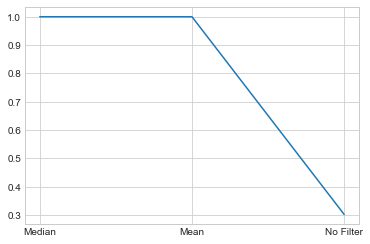

In [16]:
selected_filter = apply_filter()

# Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [18]:
conclusion_cols=['K Parameter','Init Parameter','Algorithnm','Preprocessing','Preprocessing Distance','Filtering']
conclusion_list = [4,selected_init_param,selected_algorithm,selected_preprocessing,selected_distance,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('K-Means Clustering Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../parameters_results_clustering.csv',mode='a',index=False,header=False)

,K Parameter,Init Parameter,Algorithnm,Preprocessing,Preprocessing Distance,Filtering
0,4,random,auto,StandardScaler,auto,Median


### Best Result

In [23]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis']
result = compute_KMeans(n_clusters=4,init_parameter=selected_init_param,scaler=selected_preprocessing,
                        precompute_distances=selected_distance,algorithms=selected_algorithm,labels=list(dict_zones.values()),trainX_data=get_median_filter())
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure']))
statistical_cols_csv = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis']
statistical_cols_csv.append('Experimentation')
result_csv = result
result_csv.append('K-Means Clustering Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../tests_results_clustering.csv',mode='a',index=False,header=False)

,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis
0,0.029982,0.0,1.0,1.0,1.0,1.0,1.386294


#### Added cluster to classify

,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,cluster
0,-81,-78,1
1,-83,-78,1
2,-84,-78,1
3,-83,-77,1
4,-81,-78,1
...,...,...,...
115,-78,-76,2
116,0,-70,3
117,-82,-76,2
118,-76,-71,2


1    65
2    32
0    20
3     3
Name: cluster, dtype: int64

array([[ 0,  0, 20,  0],
       [12, 30,  8, 15],
       [15,  0,  2, 15],
       [ 3,  0,  0,  0]], dtype=int64)

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,20.000000
1,1.000000,0.461538,0.631579,65.000000
2,0.066667,0.062500,0.064516,32.000000
3,0.000000,0.000000,0.000000,3.000000
accuracy,0.266667,0.266667,0.266667,0.266667
macro avg,0.266667,0.131010,0.174024,120.000000
weighted avg,0.559444,0.266667,0.359310,120.000000


,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,cluster
0,-81,-78,1
1,-83,-78,1
2,-84,-78,1
3,-83,-77,1
4,-81,-78,1
...,...,...,...
115,-78,-76,2
116,0,-70,3
117,-82,-76,2
118,-76,-71,2


Confusion Matrix:
[[25  0  1  4]
 [ 0 27  1  2]
 [ 2  0 27  1]
 [ 5  3  4 18]]


,precision,recall,f1-score,support
Bathroom,0.781250,0.833333,0.806452,30.000000
Bedroom,0.900000,0.900000,0.900000,30.000000
Kitchen,0.818182,0.900000,0.857143,30.000000
Living Room,0.720000,0.600000,0.654545,30.000000
accuracy,0.808333,0.808333,0.808333,0.808333
macro avg,0.804858,0.808333,0.804535,120.000000
weighted avg,0.804858,0.808333,0.804535,120.000000


,zone,zone_predicted,error
0,Kitchen,Kitchen,0
1,Kitchen,Kitchen,0
2,Kitchen,Kitchen,0
3,Kitchen,Kitchen,0
4,Kitchen,Kitchen,0
...,...,...,...
115,Bathroom,Bathroom,0
116,Bathroom,Bathroom,0
117,Bathroom,Kitchen,1
118,Bathroom,Bathroom,0


['mae', 'mse', 'rmse', 'precision', 'accuracy', 'f1-score']

[0.19166666666666668,
 0.19166666666666668,
 0.43779751788545657,
 0.8053544372294372,
 0.8083333333333333,
 0.8050776028886627]

,mae,mse,rmse,precision,accuracy,f1-score
0,0.191667,0.191667,0.437798,0.805354,0.808333,0.805078


,time,inertia,homonegeity_score,completeness_score,v_measure,rand_score,mis
0,1.265342,63.979796,0.33576,0.432821,0.378162,0.229918,0.465462


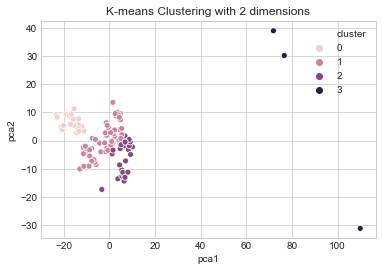

In [24]:
statistical_cols = ['time','inertia','homonegeity_score','completeness_score','v_measure','rand_score','mis']
result = compute_KMeans(flag=2,n_clusters=4,init_parameter=selected_init_param,scaler=selected_preprocessing,
                        precompute_distances=selected_distance,algorithms=selected_algorithm)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['v_measure'],ascending=False))